In [73]:
import os
import site
import random
import pandas as pd 
import numpy as np
from glob import glob
from os.path import join
from tqdm.auto import tqdm
from pathlib import Path

site.addsitedir('../include')
from visualize import plot_action_list
from utils import get_labels_start_end_time, get_labels, process_annotation


## Notebook for data prepartion informative frames
This script prepares data for the informative frame experiment needed for video experimentation wiht Paxos Scope DR detection
- Around 70 PaxoScope Videos that show in a video a mix of 
    - background frames
    - informative frames

In [74]:
base_dir = Path("/home/simon/Data/2025_Paxos_Info")
video_dir = base_dir / "videos_ds" / "out"
feat_dir = base_dir / "features"
gt_dir = base_dir / "groundTruth"
col_id = "EYE_ID"
videos = os.listdir(video_dir)
features = os.listdir(feat_dir)
os.makedirs(gt_dir, exist_ok=True)

df = pd.read_csv(base_dir / "annotations.csv")
df = df.drop(columns=["Duration", "Comments"])
labels = ["background", "Fundus_Visibile"]
labels_raw = df.columns[1:]
print(sorted(videos))
df.head()

['R008R.MOV.mp4', 'R008R2.MOV.mp4', 'R008R3.MOV.mp4', 'R009L.MOV.mp4', 'R011L.MOV.mp4', 'R011R.MOV.mp4', 'R012L3.MOV.mp4', 'R017R.MOV.mp4', 'R017R2.MOV.mp4', 'R017R3.MOV.mp4', 'R018L.MOV.mp4', 'R018R.MOV.mp4', 'R018R2.MOV.mp4', 'R020L2.MOV.mp4', 'R020R.MOV.mp4', 'R022L.MOV.mp4', 'R022R.MOV.mp4', 'R023L.MOV.mp4', 'R023L2.MOV.mp4', 'R023R.MOV.mp4', 'R024R.MOV.mp4', 'R026L.MOV.mp4', 'R026L2.MOV.mp4', 'R026R.MOV.mp4', 'R027L.MOV.mp4', 'R027R.MOV.mp4', 'R028R.MOV.mp4', 'R028R2.MOV.mp4', 'R029L2.MOV.mp4', 'R030R.MOV.mp4', 'R031R.MOV.mp4', 'R033R2.MOV.mp4', 'R034L2.MOV.mp4', 'R034L3.MOV.mp4', 'R034R.MOV.mp4', 'R034R2.MOV.mp4', 'R035R.MOV.mp4', 'R036L.MOV.mp4', 'R036R.MOV.mp4', 'R036R2.MOV.mp4', 'R037L.MOV.mp4', 'R037R.MOV.mp4', 'R037R2.MOV.mp4', 'R038R.MOV.mp4', 'R040R2.MOV.mp4', 'R041R2.MOV.mp4', 'R042L.MOV.mp4', 'R042R.MOV.mp4', 'R043R.MOV.mp4', 'R044R.MOV.mp4', 'R045L.MOV.mp4', 'R045R.MOV.mp4', 'R047L.MOV.mp4', 'R047R.MOV.mp4', 'R047R2.MOV.mp4', 'R049L3.MOV.mp4', 'R050R.MOV.mp4', 'R052L.MO

,EYE_ID,Fundus_Visibile_Start,Fundus_Visibile_Stop,Fundus_Visibile_Start.1,Fundus_Visibile_Stop.1,Fundus_Visibile_Start.2,Fundus_Visibile_Stop.2,Fundus_Visibile_Start.3,Fundus_Visibile_Stop.3,Fundus_Visibile_Start.4,...,Fundus_Visibile_Start.8,Fundus_Visibile_Stop.8,Fundus_Visibile_Start.9,Fundus_Visibile_Stop.9,Fundus_Visibile_Start.10,Fundus_Visibile_Stop.10,Fundus_Visibile_Start.11,Fundus_Visibile_Stop.11,Fundus_Visibile_Start.12,Fundus_Visibile_Stop.12
0,R022L,00:01,00:04,00:08,00:08,00:14,00:16,00:33,00:41,00:48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R023L2,00:04,00:08,00:36,00:38,00:41,00:45,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R036R2,00:07,00:13,00:29,0.31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R069R,00:09,00:12,00:25,00:32,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R047L,00:03,00:07,00:11,0.11,00:19,00:23,00:28,00:31,0.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Create mapping fiel
mapping_path = "/home/simon/Data/2025_Paxos_Info/mapping.txt"
os.remove(mapping_path) if os.path.exists(mapping_path) else None
mapping = {}
for i, label in enumerate(labels):
    open(mapping_path, 'a').write(f"{i} {label}\n")
    mapping[label] = i
mapping

{'background': 0, 'Fundus_Visibile': 1}

In [76]:
# Find video matches for each annotation
to_drop = []
df.insert(loc=1, column='feature', value="")
df.insert(loc=2, column='video', value="")
for i in range(30): # add empty columns for compatibility
    df[str(i)] = np.nan

for i, row in df.iterrows():
    if not os.path.exists(str(feat_dir / row["EYE_ID"]) + ".MOV_rgb.npy"):
        print(f"Missing feature for {row['EYE_ID']}")
        to_drop.append(i)
    else:
        df.at[i, "feature"] = str(feat_dir / row["EYE_ID"]) + ".MOV_rgb.npy"
        df.at[i, "video"] = str(video_dir / row["EYE_ID"]) + ".MOV.mp4"
df = df.drop(to_drop)

Missing feature for R054R
Missing feature for R010R


In [ ]:
for i, row in df.iterrows():
    feat = np.load(row["feature"])
    frames_to_label = {}
    
    cur_annotation = process_annotation(row, video_dir, mapping, col_name="video", fps=30, start_idx=3)
    #print(len(anno), np.count_nonzero(anno))
    #print(anno[500:1000])
    
    # sanity check
    # class_dict = dict(zip(*np.unique(cur_annotation, return_counts=True)))
    inv_class = {v: k for k, v in mapping.items()}
    # class_occurence = {inv_class[k]: v/30.0 for k, v in class_dict.items()}
    # background_count, total_count = class_occurence["background"], sum(class_occurence.values())
    # bg_perc.append(background_count / total_count)
    # print(f'Percentage of background: {background_count / total_count}, {class_occurence}')
    
    #convert and write to file
    anno_list = [inv_class[elm] for elm in cur_annotation.tolist()]
    with open(join(gt_dir, f'{os.path.splitext(row["EYE_ID"])[0]}.txt'), 'w') as f:
        f.write("\n".join(anno_list))
        pass
    

## Sanity check

R034R.txt
R008R3.txt
R037L.txt
R011L.txt


R041R2.txt
Sanity check on gt file: R041R2.txt
Timestamp: 6sec - 0:06, class Fundus_Visibile
Timestamp: 50sec - 0:50, class Fundus_Visibile
Timestamp: 18sec - 0:18, class background
Timestamp: 37sec - 0:37, class background
Timestamp: 32sec - 0:32, class background
Timestamp: 20sec - 0:20, class background
Timestamp: 15sec - 0:15, class background
Timestamp: 14sec - 0:14, class Fundus_Visibile
Timestamp: 5sec - 0:05, class Fundus_Visibile
Timestamp: 2sec - 0:02, class Fundus_Visibile

Sanity check on gt file: R057L.txt
Timestamp: 79sec - 1:19, class Fundus_Visibile
Timestamp: 33sec - 0:33, class background
Timestamp: 59sec - 0:59, class background
Timestamp: 53sec - 0:53, class background
Timestamp: 44sec - 0:44, class background
Timestamp: 68sec - 1:08, class background
Timestamp: 10sec - 0:10, class background
Timestamp: 55sec - 0:55, class background
Timestamp: 46sec - 0:46, class background
Timestamp: 39sec - 0:39, class background

Sanity check on gt file: R024R.txt
Timestamp: 6se

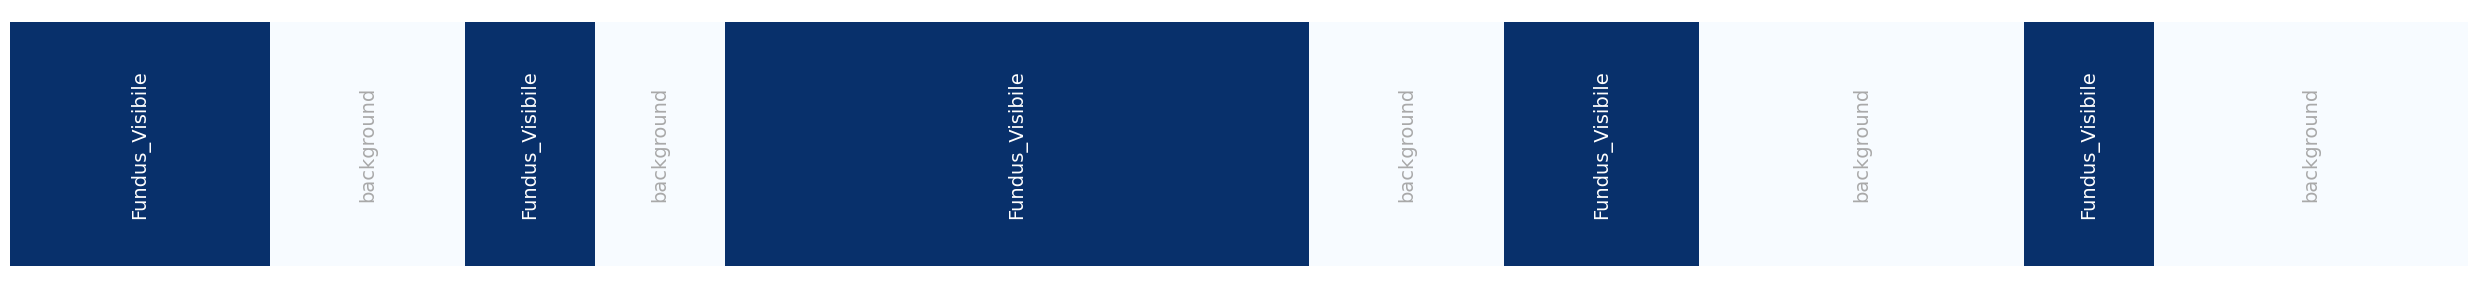

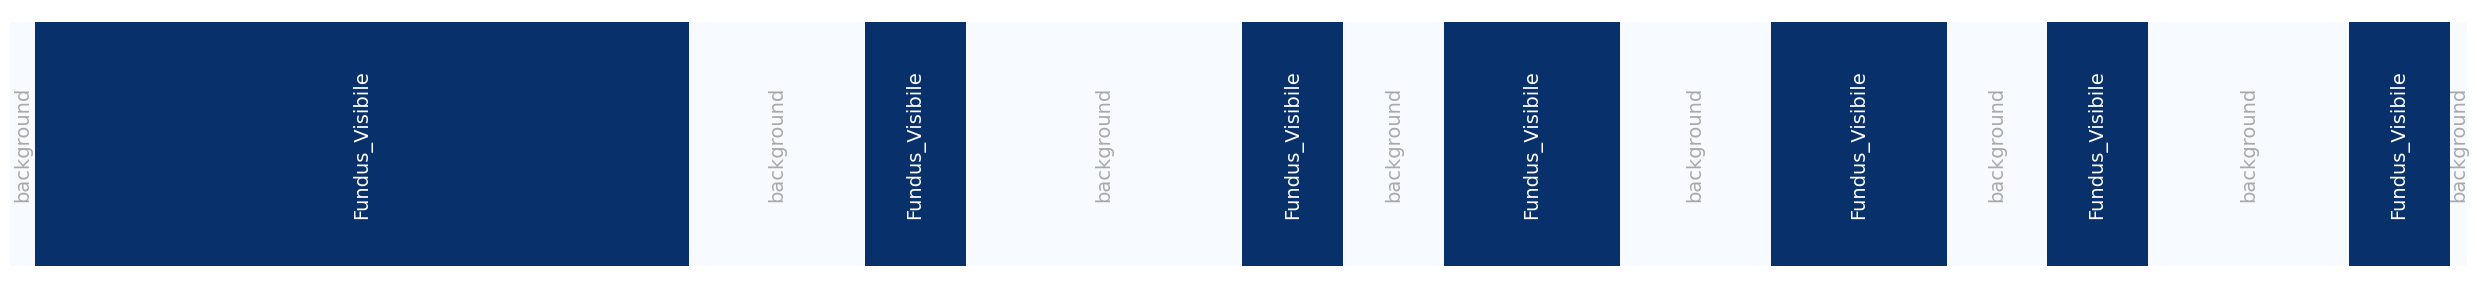

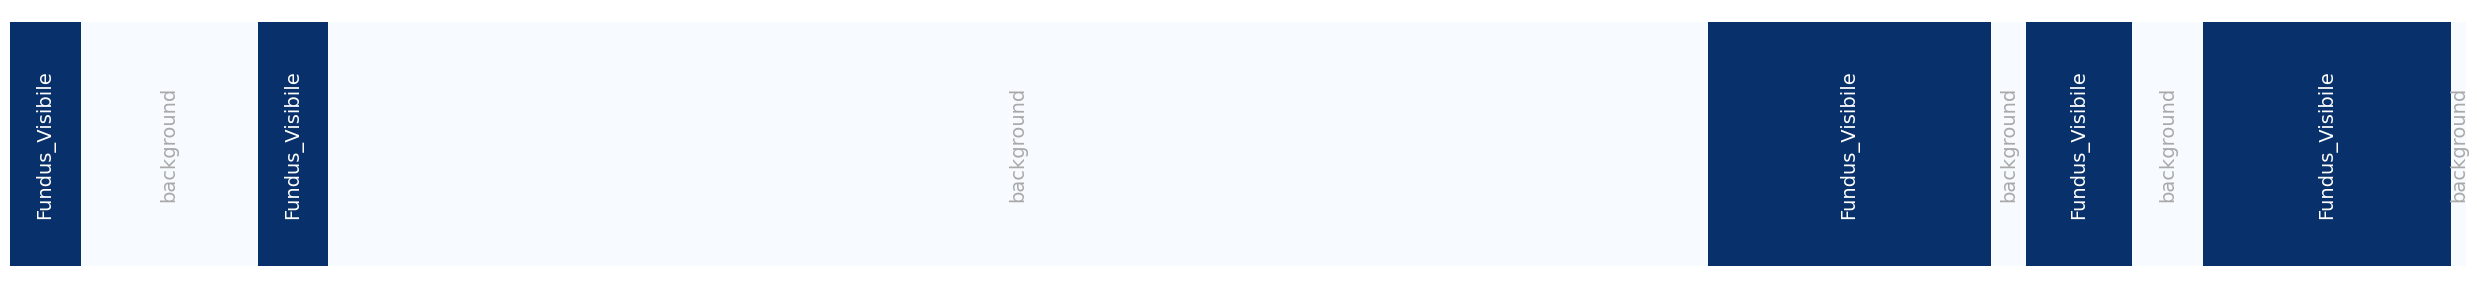

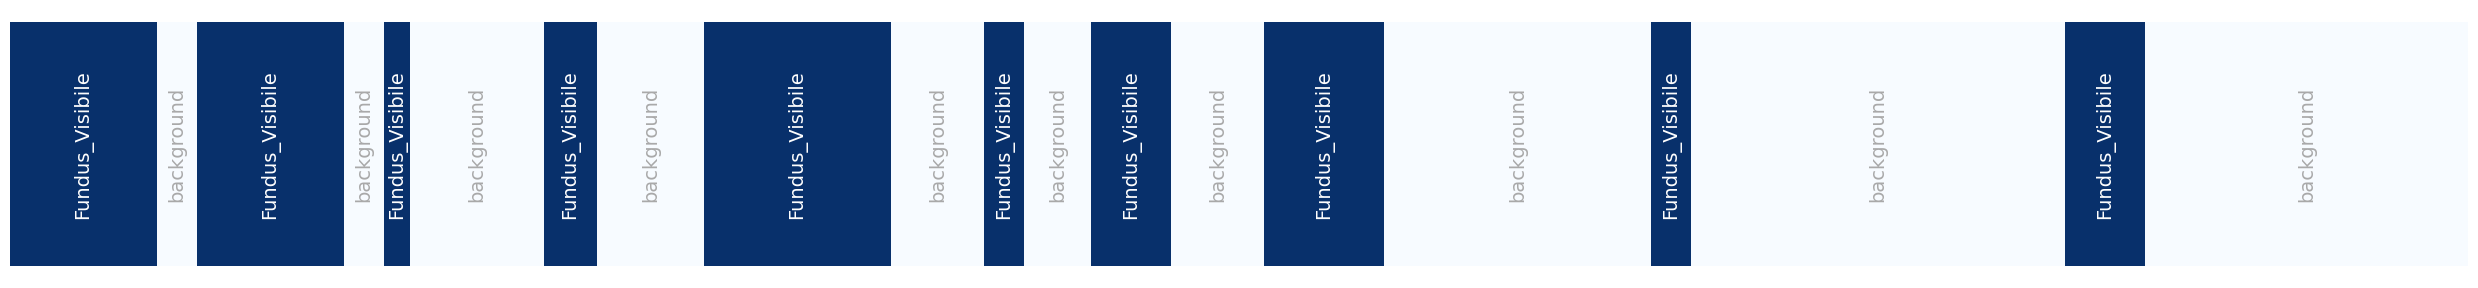

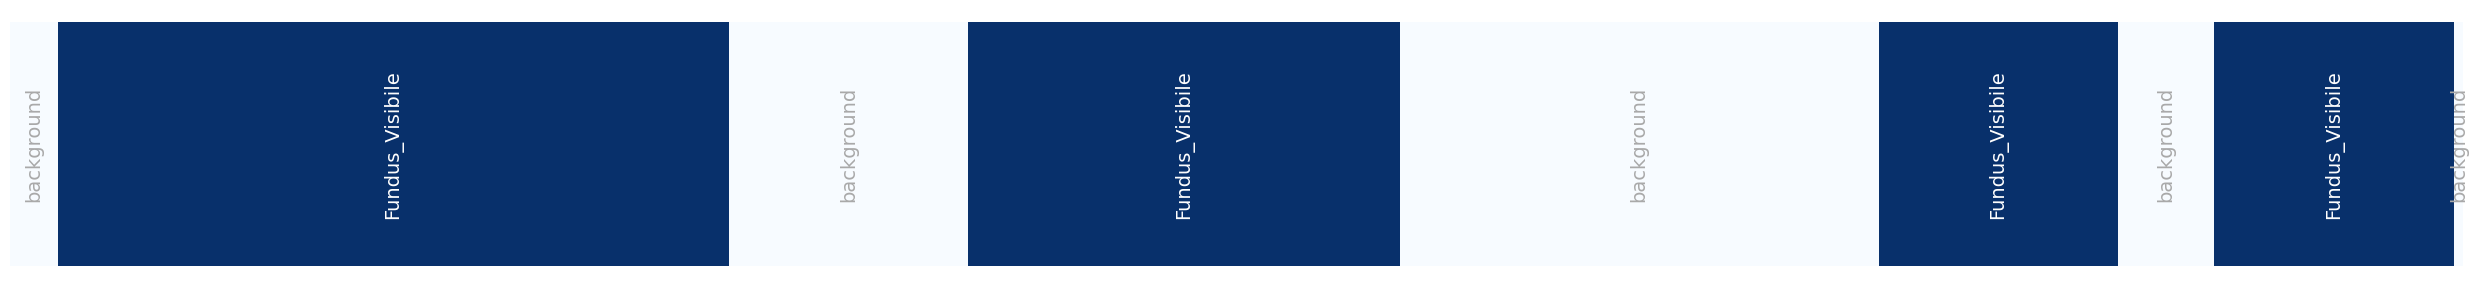

In [81]:
import random

gt_files = os.listdir(gt_dir)
# Plot the first 5 ground truth files
for file in random.sample(gt_files, 5): 
    cur_gt = open(join(gt_dir, file), 'r').read().split('\n')
    #print(list(set(cur_gt)), cur_gt[-1])
    #print(cur_gt[-10:])
    plot_action_list(cur_gt, labels)
    print(file)
    

selected_files = random.sample(gt_files, 5) # Randomly select 10 files
FPS = 30

for file in selected_files: # Iterate over the selected files
    print(f"Sanity check on gt file: {file}")
    with open(join(gt_dir, file), 'r') as f:
        lines = f.readlines()
        selected_lines = random.sample(list(enumerate(lines)), 10) # Randomly select 10 lines with line numbers
        for line_number, line in selected_lines: # Print the selected lines with line numbers
            print(f"Timestamp: {int((line_number + 1) / FPS)}sec - {int((line_number + 1) / FPS // 60)}:{int((line_number + 1) / FPS % 60):02d}, class {line.strip()}")
    print()